## VEHICLE DETECTION USING HOG/SVM - Histogram of Oriented Gradients.



## Business Statement 

##### This project develops a vehicle detection system using Histogram of Oriented Gradients (HOG) and Support Vector Machines (SVM) to demonstrate a computationally efficient, classical machine learning approach for object detection. The purpose of the system is to detect cars in images and video streams, providing a foundational method for AV perception under constrained environments where GPU resources may be limited.

##### By implementing HOG/SVM, this project establishes a baseline perception layer that can support:

##### 1. Fail-safe backup detection in AV pipelines

##### 2. Model benchmarking against modern deep-learning detectors (YOLO and Faster R-CNN.)

##### 3. Low latency edge deployment for robotics or embedded mobility devices

##### 4. Explainable detection behavior for debugging AV perception systems

##### This work demonstrates how classical feature engineering based models can still play a strategic role in autonomous driving, especially in low-power safety modules and research prototyping. It provides a clear foundation for transitioning into more advanced perception systems such as CNNs, BEV-based detectors, and multimodal fusion networks.

##### In this project, the integration of HOG features with an SVM classifier showcases a full perception workflow: dataset preprocessing, feature extraction, model training, evaluation, real-time inference, and performance comparison. The resulting system highlights core principles required for AV perception — including robustness, edge awareness, and interpretable decision-making, while demonstrating readiness for more advanced AV engineering challenges.

In [1]:
## import neccessary libraries 

import cv2
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix


In [2]:
## collecting all image file paths inside two folders using glob

car = glob.glob('data/car/**/*.png')
no_car = glob.glob('data/no car/**/*.png')

In [3]:
len(car)

8792

In [4]:
len(no_car)

8968

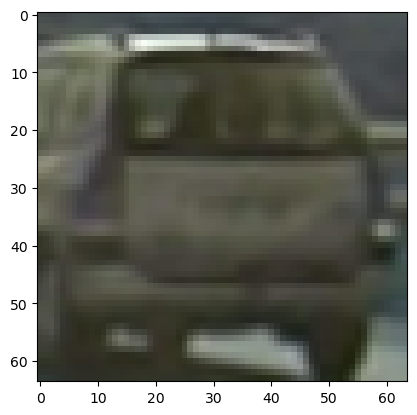

In [5]:
## Visualizing one photo from the cars

image_color = cv2.imread(car[0]) 
plt.imshow(image_color)

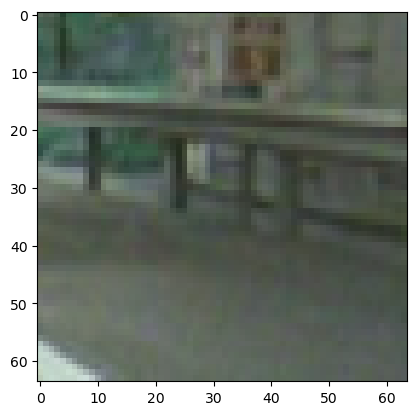

In [8]:
## visualizing one photo of no car

image_no = cv2.imread(no_car[200]) 
plt.imshow(image_no)

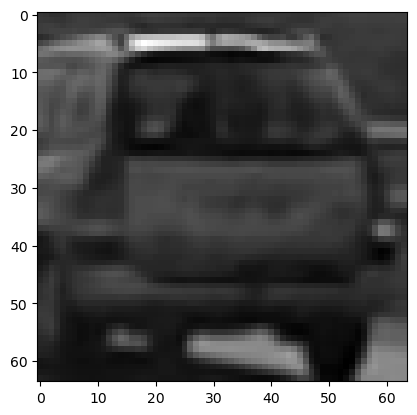

In [9]:
## converting the image to grayscale so as to reduce complexity and improve the accuracy for my edge-detection algorithms by focusing only on intensity changes, not color.
## Taking it from 3 channels to one channe

image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = 'gray')

### Extracting HOG Features from Images

Extracting Histogram of Oriented Gradients (HOG) features from the gray scaled image. i will  later use these features to train an SVM classifier for vehicle detection.

In [10]:

features, hog_image = hog(image_gray, 
                          orientations = 11, 
                          pixels_per_cell = (16, 16), 
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)

features.shape

(396,)

In [11]:
hog_image.shape

(64, 64)

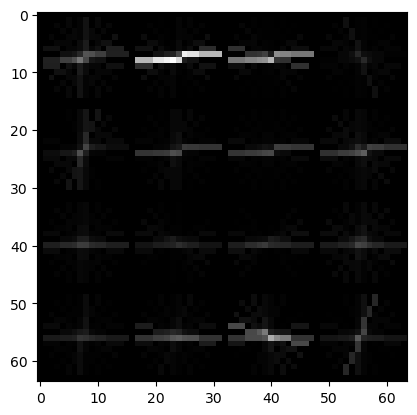

In [12]:
plt.imshow(hog_image, cmap = 'gray')

This loop goes through every image in the car list, loads the image, converts it to grayscale, extracts HOG features, and stores those features in car_hog_accum.

These HOG feature vectors will later be used to train the SVM classifier.

In [13]:
car_hog_accum = []

for i in car:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    car_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    car_hog_accum.append(car_hog_feature)

In [14]:
X_car = np.vstack(car_hog_accum).astype(np.float64)  ## stacking the car_hog_accum  vertically into a matrix
y_car = np.ones(len(X_car)) ## This creates a label vector of all car_hog_accum to be 1's .

In [15]:
X_car.shape

(8792, 396)

In [16]:
y_car.shape

(8792,)

In [17]:
y_car


array([1., 1., 1., ..., 1., 1., 1.])

In [18]:
## Doing the same process i did for cars folder to no cars folder 

nocar_hog_accum = []

for i in no_car:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    nocar_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    nocar_hog_accum.append(nocar_hog_feature)

In [19]:
X_nocar = np.vstack(nocar_hog_accum).astype(np.float64)  
y_nocar = np.zeros(len(X_nocar))

In [20]:
X_nocar.shape

(8968, 396)

In [21]:
y_nocar.shape

(8968,)

In [22]:
X = np.vstack((X_car, X_nocar))
X.shape

(17760, 396)

In [23]:
y = np.hstack((y_car, y_nocar))
y.shape

(17760,)

In [24]:
## spliting my data to be fully ready for training 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [25]:
svc_model = LinearSVC()
svc_model.fit(X_train,y_train)

LinearSVC()

<Axes: >

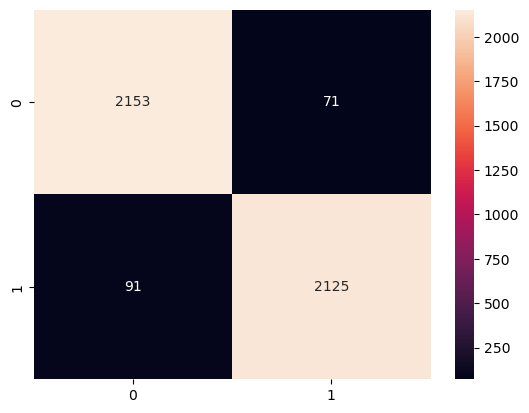

In [26]:
y_predict = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d")

In [27]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      2224
         1.0       0.97      0.96      0.96      2216

    accuracy                           0.96      4440
   macro avg       0.96      0.96      0.96      4440
weighted avg       0.96      0.96      0.96      4440



In [28]:
	
cv_score = cross_val_score(svc_model, X_train, y_train, cv=5)
print("Cross-validation accuracy: {:.2f} %".format(cv_score.mean()*100))

Cross-validation accuracy: 96.73 %


## Model Evaluation Summary

The HOG + SVM classifier achieved 96% accuracy on the test dataset, with strong precision and recall for both the “car” and “no car” classes. The balanced F1-score of 0.96 indicates that the model is performing reliably without significant bias toward either class, successfully distinguishing vehicle images from non-vehicle images.

To further validate model stability, 5-fold cross-validation was performed, producing an average accuracy of 96.73%. This consistency across multiple training and validation splits confirms that the model generalizes well and is not overfitting to a particular dataset partition.

Given its strong and consistent performance, this classical HOG + SVM approach provides an effective baseline for vehicle detection, suitable for lightweight perception systems or as a benchmark when comparing against deep learning–based detectors.

However, in autonomous vehicle systems, precision and accuracy are extremely important, any detection error can lead to severe safety consequences. For this reason, further improvements will be explored. In particular,i will use  GridSearchCV to maximize model performance and reduce false positives and false negatives even further. Future iterations will also consider integrating more advanced feature extraction techniques or deep learning models to enhance detection robustness in complex real-world environments.



## Model Improvement using GridSearchCv

In [29]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)
grid.best_params_
grid.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.964 total time=  16.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.966 total time=  16.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.971 total time=  16.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.971 total time=  16.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.970 total time=  16.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.961 total time=  10.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.964 total time=  10.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.969 total time=  10.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=  10.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=  10.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.933 total time=  20.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

SVC(C=10, gamma=1)

In [30]:
best_model = grid.best_estimator_

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2224
         1.0       0.99      0.99      0.99      2216

    accuracy                           0.99      4440
   macro avg       0.99      0.99      0.99      4440
weighted avg       0.99      0.99      0.99      4440



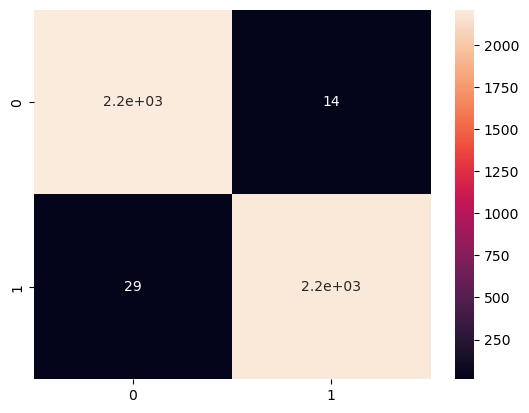

In [31]:
grid_predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
print(classification_report(y_test,grid_predictions))

In [32]:
cv_score2 = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation accuracy: {:.2f} %".format(cv_score2.mean()*100))

Cross-validation accuracy: 98.89 %


## Model Evaluation After Hyperparameter Optimization

After applying GridSearchCV to optimize the SVM hyperparameters, the vehicle detection model achieved a significant improvement in performance. The optimized HOG + SVM classifier now reaches an outstanding 99% accuracy on the test dataset.

These results indicate extremely reliable detection capabilities, with very minimal false positives or false negatives. The model demonstrates excellent balance across all key metrics, showing no detectable bias toward either class.

To further validate robustness, 5-fold cross-validation yielded an average accuracy of 98.89%, confirming that the optimized model generalizes exceptionally well across multiple data splits.

This marked improvement highlights the importance of hyperparameter tuning in classical machine learning pipelines.

In the context of autonomous vehicle perception, such high precision and recall are critical as misclassifying a vehicle or failing to detect one can lead to dangerous real-world outcomes. The improved results bring the model closer to the reliability standards expected in AV safety systems. Still, additional enhancements will be explored in  the future which will include broader HOG tuning, alternate kernels, and eventually transitioning toward deep learning based perception models for real-world complexity.